In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

car=pd.read_csv("car_prediction_data.csv")
car.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [2]:
#how we will go about this:
#drop unreasonable data(car name)
#convert categorical inputs to integers
#look for strong correlations and apply stratified shuffle split
#look for the best model, fit, train, evaluate
#lets goo

In [3]:
#copy the data in order to have the original safe
cars=car.copy()

In [7]:
#look for correlations
cars_correlation = cars.corr()
cars_correlation["Present_Price"].sort_values(ascending=True)
#cars.drop("Car_Name",axis=1,inplace=True)
#labels=cars["Present_Price"].copy()

Year            -0.047584
Owner            0.008057
Kms_Driven       0.203647
Selling_Price    0.878983
Present_Price    1.000000
Name: Present_Price, dtype: float64

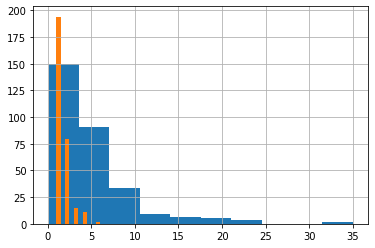

In [8]:
cars["Selling_Price"].hist()
cars["sell_category"]=pd.cut(cars["Selling_Price"],bins=[0,5,10,15,25,30,35,np.inf],labels=[1,2,3,4,5,6,7])
cars["sell_category"].hist()

In [9]:
#there is a great correlation between Present price and selling price so lets bring in strata
#first though lets categorize our desired strata

from sklearn.model_selection import StratifiedShuffleSplit
strata=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=369)
for trainer,tester in strata.split(cars,cars["sell_category"]):
    train_set=cars.loc[trainer]
    test_set=cars.loc[tester]

In [10]:
#now drop the column you just created for the strata 
for x in (train_set,test_set):
    x.drop("sell_category",axis=1,inplace=True)
cars.drop("sell_category",axis=1,inplace=True)

In [12]:
train_set.tail()
train_labels=train_set["Present_Price"].copy()

In [17]:
train_set["Transmission"]=train_set["Transmission"].replace({"Manual":1,"Automatic":2})
trained=train_set.copy()

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

piper=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("std",StandardScaler())
])
trainee=train_set.copy()

In [15]:
categories=["Fuel_Type","Seller_Type"]
trainee.drop("Fuel_Type",axis=1,inplace=True)
trainee.drop("Seller_Type",axis=1,inplace=True)
numbers=list(trainee)

In [60]:
full_pipeline=ColumnTransformer([
    ("piper",piper,numbers),
    ("strings",OneHotEncoder(),categories)
])
trans=full_pipeline.fit_transform(trained)

In [19]:
#now lets find the best model

from sklearn.linear_model import Ridge
rig=Ridge(alpha=1,solver="cholesky")
rig.fit(trans,train_labels)


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='cholesky', tol=0.001)

In [39]:
#lets get all the models in, remember no free lunch here
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

elastic=ElasticNet(alpha=0.1,l1_ratio=0.5)
lasso=Lasso(alpha=0.1)
tree=DecisionTreeRegressor()
forest=RandomForestRegressor()
linear_regressor=LinearRegression()
svm=LinearSVR(loss="hinge",C=1)

In [40]:
#stuff is quite linear so no need for the biffer robust models and blenders
#use cross val score to get the best of all using a function though
from sklearn.model_selection import cross_val_score

def scorer(x):
    x.fit(trans,train_labels)
    score=cross_val_score(x,trans,train_labels,cv=10,scoring="neg_mean_squared_error")
    means=score.mean()
    error=np.sqrt(-means)
    print(x)
    return error


In [41]:
#now lets find the errors fam, and get the best of all

print(scorer(elastic))
print(scorer(lasso))
print(scorer(tree))
print(scorer(forest))
print(scorer(rig))
print(scorer(linear_regressor))

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
1.0848756744070371
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
0.13444657359593723
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
3.67866694379001


C:\Users\user\Anaconda4\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
3.707780727239903
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='cholesky', tol=0.001)
0.1701903175972088
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
9.542954605694157e-15


In [99]:
#from the above ridge is good , lasso is better, but linear regression is unbelievablebly great
#lets goo
#lets deploy the test set now

test_labels=test_set["Present_Price"].copy()
#test_set["Transmission"]=test_set["Transmission"].replace({"Manual":1,"Automatic":2})
#clean up the test set by putting it in the pipeline
cleaned=full_pipeline.transform(test_set)

#remember you dont fit the test set to the model,just predict
linear=linear_regressor.predict(cleaned)
#accuracy=accuracy_score(test_labels,test_predictions)
#after a tonne of errors, found out that accuracy and precision scores work for classification tasks



In [100]:
#lets see how our model performs on the test set using mean squared error
from sklearn.metrics import mean_squared_error

errors=mean_squared_error(test_labels,linear)
mean_error=errors.mean()
print(mean_error)


7.524452955420498e-29


In [ ]:
#error almost zero..would have been perfect if not for entropy
